# Net Benefit (DCA)

## Set Up

libraries/packages

In [1]:
import sys
import os

sys.path.append(os.path.abspath("../"))
from src.config import BASE_PATH
import matplotlib.pyplot as plt
from statkit.decision import NetBenefitDisplay
from src.data_utils import get_data, get_models
import pandas as pd

Data/models

In [2]:
# Data
file_dir = BASE_PATH / "data" / "processed"
OUTCOME_DICT = {
    "med": get_data("med_outcome", file_dir),
    "surg": get_data("surg_outcome", file_dir),
    "mort": get_data("mort_outcome", file_dir),
    "reop": get_data("reop_outcome", file_dir),
    "vte": get_data("vte_outcome", file_dir),
}

# Models
model_dir = BASE_PATH / "models" / "calibrated"
model_prefix_list = ["lgbm", "lr", "xgb", "nn", "stack"]
MODEL_DICT = {}
for outcome in OUTCOME_DICT.keys():
    MODEL_DICT[outcome] = get_models(model_prefix_list, outcome, model_dir)


SAVE_PATH = BASE_PATH / "results" / "figures" / "DCA"

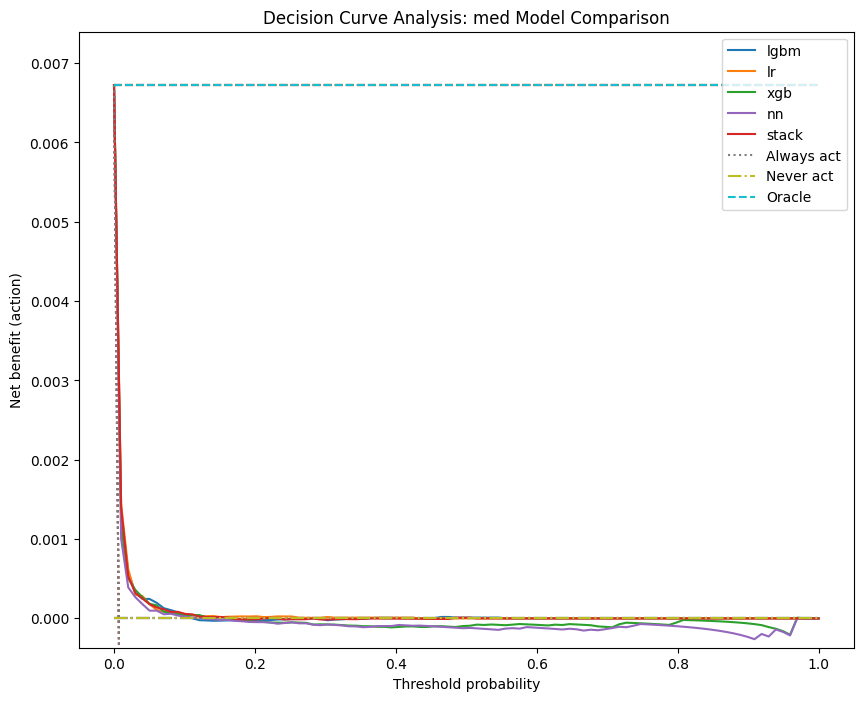

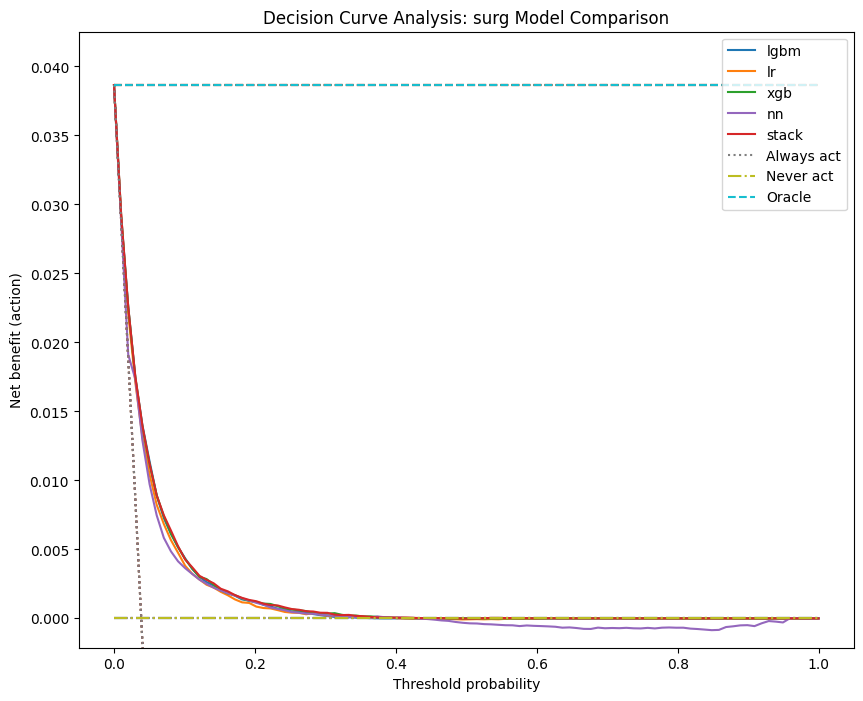

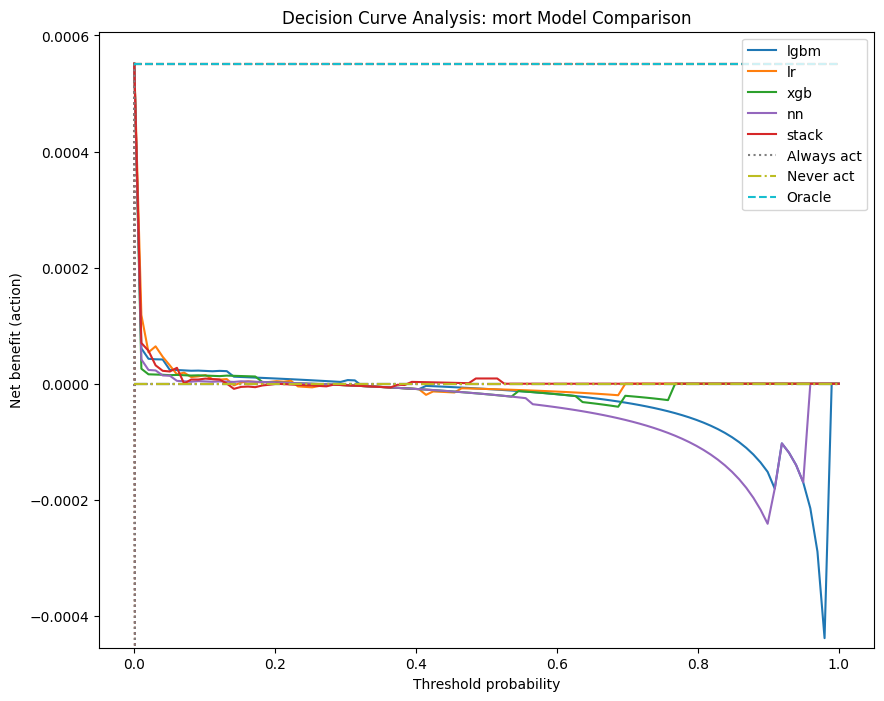

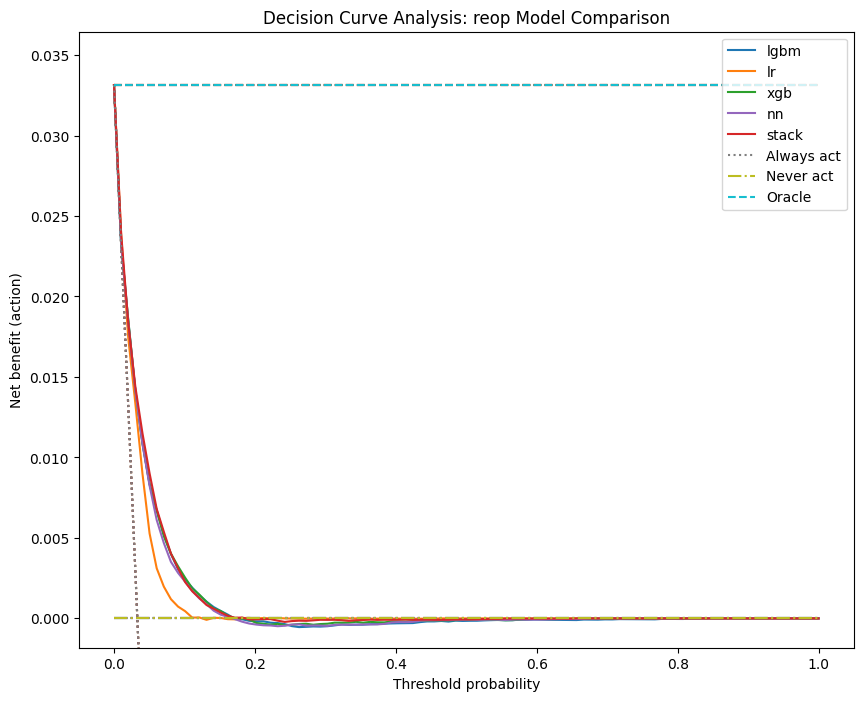

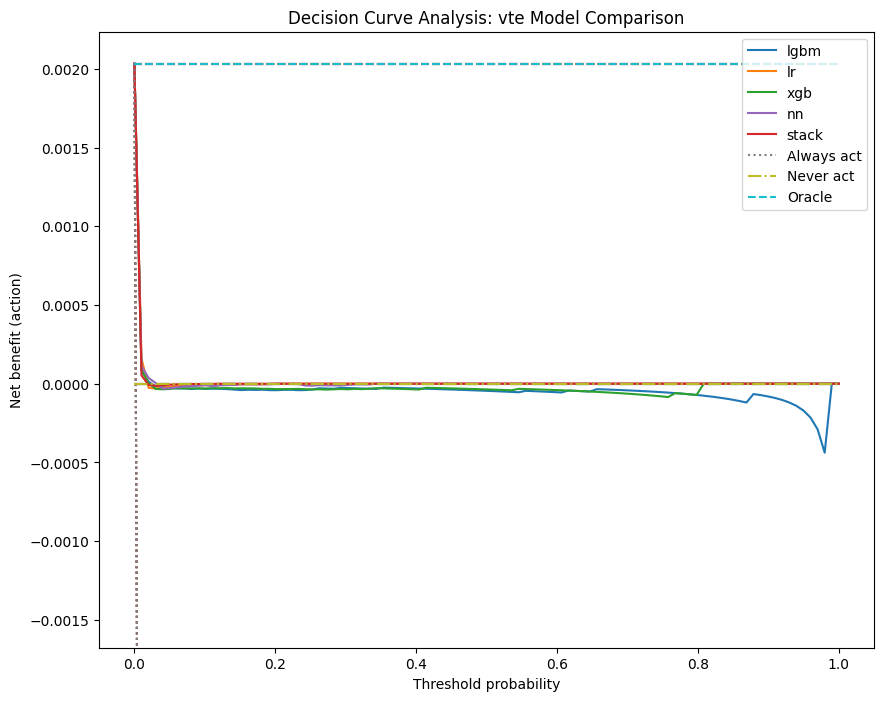

In [15]:
color_list = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:purple",
    "tab:red",
    "tab:olive",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
]
for outcome_name, sub_dict in OUTCOME_DICT.items():
    X_test = sub_dict['X_test']
    y_test = sub_dict['y_test']
    ratio = y_test.value_counts(normalize=True).loc[1][1]
    model_dict = MODEL_DICT[outcome_name]
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    for (model_name, model), color in zip(model_dict.items(), color_list):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        NetBenefitDisplay.from_predictions(
            y_test.values.ravel(),
            y_pred_proba,
            name=model_name,
            ax=ax,
        )
    model_names = list(model_dict.keys())
    lines = [line for line in ax.get_lines() if line.get_label() in model_names]
    for line, color in zip(lines, color_list):
        line.set_color(color)


    # Get all handles and labels
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicates

    # # Separate baselines from models
    baseline_labels = ["Always act", "Never act", "Oracle"]
    model_labels = [name for name in model_names if name in by_label]

    # # Models first, then baselines
    ordered_labels = model_labels + baseline_labels

    # # Create ordered handles and labels
    ordered_handles = [by_label[label] for label in ordered_labels if label in by_label]
    final_labels = [label for label in ordered_labels if label in by_label]

    ax.legend(ordered_handles, final_labels, loc="upper right")

    plt.title(f"Decision Curve Analysis: {outcome_name} Model Comparison")
    y_max = ratio + (0.1*ratio)
    
    y_min = (y_max - (1.05*y_max)) if outcome_name not in ['vte', 'mort'] else y_max - (1.75*y_max)
    plt.ylim(y_min, y_max)


    export_path = SAVE_PATH / f"{outcome_name}.pdf"
    if export_path.exists():
        export_path.unlink()
    export_path.parent.mkdir(exist_ok=True, parents=True)
    plt.savefig(export_path, bbox_inches="tight")
    plt.show()
    plt.close()